This script generates PACBED images based on an input .cif file, and automatically creates a thickness series of images.  The settings which may commonly be adjusted are collected in the settings dictionary just after the imports.

The basic logic of the script is:

   1.  Read the .cif file
   2.  Initialize a pixelated detector to capture the PACBED(s)
   3.  Generate a full-thickness model from the .cif file
   4.  Setup other needed objects (probe, grid scan, frozen phonon configs, etc)
   5.  Generate a potential object for each frozen phonon configuration
   6.  Slice the potential into chunks (of "thickness_step") along propagation direction
   7.  Propagate the probe through that chunk for each position in the gridscan
   8.  Detect the probes and store those measurements into a list
   9.  Sum together the measurement from each probe position to get PACBED(s) for each thickness
   10. Export the PACBED(s) as a .tif stack

In [1]:
from importlib import reload
import graphical
reload(graphical)
import abtem_backend as backend
reload(backend)
from ase.visualize import view

In [2]:
# Preview the cif file to make sure it looks right
# This pops up a new interactive window where you can rotate / pan / zoom / etc. with the cif model
cif_cell = graphical.gui_open(ffmt="cif")
view(cif_cell)
# Technically, reading the cif returns a generator (because cifs can store multiple crystal structures in one file),
# in which case this only shows the first valid structure.  But practically, just avoid using cif files with multiple structures in them

<Popen: returncode: None args: ['C:\\Users\\charles\\.jupyter\\venv\\Scripts...>

In [2]:
# Build the models
models = backend.build_from_cif(graphical.gui_get_path(),
                                zas=[(1, 0, 0), (1, 1, 0), (1, 2, 0), (1, 1, 1)],
                                tks=300,
                                tilings=[(10, 10), (8, 10), (5, 10), (10, 5)])

In [3]:
# Preview the models in an interactive window
# WARNING: This will lag *badly* for large models!  Feel free to skip
for model in models:
    view(model.atoms)

In [3]:
det = backend.DetectorBuilder()
potential_parameters = backend.PotentialParameters(sampling=0.1,
                                                   slice_thickness=1,
                                                   parametrization="kirkland",
                                                   projection="infinite",
                                                   precalculate=True,
                                                   device="gpu",
                                                   storage="cpu",
                                                   seed=42,
                                                   fp_cfgs=10,
                                                   fp_sigmas={"Ba": 0.0757,  # Data from https://materials.springer.com/isp/crystallographic/docs/sd_1410590
                                                              "Ti": 0.0893,  # and from https://pubs.acs.org/doi/10.1021/acs.chemmater.9b04437 (for Zr)
                                                              "Zr": 0.1050,
                                                              "O":  0.0810})
probe_parameters = backend.ProbeParameters(max_batch=50,
                                           energy=200E3,
                                           convergence=17.9,
                                           device="gpu",
                                           tilt_mag=0, tilt_rot=0,
                                           defocus=0,
                                           stig=0, stig_rot=0,
                                           coma=0, coma_rot=0,
                                           spherical=0)
thickness_step = 20

In [4]:
# Run the simulation
results = backend.simulate_packbed_thickness_series(models, det, potential_parameters, probe_parameters,
                                                    thickness_step=thickness_step)

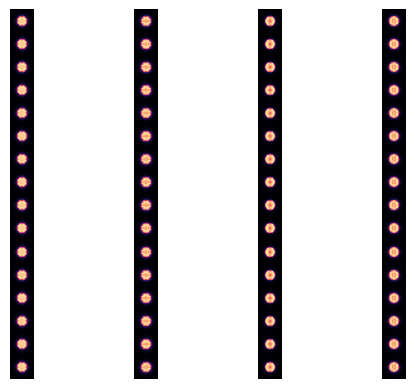

In [5]:
# Preview the results
from matplotlib import pyplot as plt
n_zas = len(results)
n_tks = len(results[0].thicknesses)
fig, axs = plt.subplots(n_tks, n_zas, frameon=False)
for i, res in enumerate(results):
    for j in range(len(res.thicknesses)):
        axs[j, i].imshow(res.measurements[-1][res.detector].sum((0, 1)).array, cmap="magma")
        axs[j, i].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)

In [6]:
backend.export_pacbed_as_tif(results=results,
                             export_path=r"E:\Users\Charles\TEST",
                             probe_prms=probe_parameters,
                             thickness_step=thickness_step)